In [ ]:
import pickle
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from functools import wraps
import time
import logging
import sys
import os

SCRIPT_PATH = Path('__file__').resolve()
PROJECT_ROOT = SCRIPT_PATH.parent.parent
sys.path.append(str(PROJECT_ROOT))
from config.config import Config

# ---------------------------
# Configuration & Logging
# ---------------------------

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(name)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler(Config.LOGS / 'data-pipeline.log', mode='w') #will chnage stdout later at inference to watch on cloudwatch
    ]
)
logger = logging.getLogger(__name__)

# ---------------------------
# Decorators & Utilities
# ---------------------------

def timed_step(func):
    """Decorator to time the execution of pipeline steps."""
    @wraps(func)
    def wrapper(self, *args, **kwargs):
        start = time.time()
        result = func(self, *args, **kwargs)
        elapsed = time.time() - start
        logger.info(f"Step '{func.__name__}' completed in {elapsed:.2f}s")
        return result
    return wrapper


def save_transformer(transformer, path: Path):
    with open(path, "wb") as f:
        pickle.dump(transformer, f)
    logger.info(f"Saved transformer to {path}")


def load_transformer(path: Path):
    with open(path, "rb") as f:
        logger.info(f"Loaded transformer from {path}")
        return pickle.load(f)

# ---------------------------
# ClinicalPipeline Definition
# ---------------------------
class ClinicalPipeline:
    def __init__(self, data_dir: Path = None):
        self.data_dir = data_dir or Config.DATA_RAW
        if not self.data_dir.exists():
            raise FileNotFoundError(f"Data directory not found: {self.data_dir}")
        self.raw_data = {}
        self.cleaned_data = {}
        self.transformed_data = None
        self.features = None
    @timed_step
    def load_raw(self):
        """
        Load multiple types of raw data files from supported formats dynamically
        """
        SUPPORTED_TYPES = {
            '.csv': (pd.read_csv, {}),
            '.parquet': (pd.read_parquet, {}),
            '.xlsx': (pd.read_excel, {'engine': 'openpyxl'}),
            '.xls': (pd.read_excel, {'engine': 'xlrd'}),
            '.json': (pd.read_json, {'orient': 'records'})
        }
        # Find all supported files
        all_files = []
        for ext in SUPPORTED_TYPES.keys():
            all_files.extend(self.data_dir.glob(f"*{ext}"))
        
        if not all_files:
            raise FileNotFoundError(f"No supported files found in {self.data_dir}")

        # Load files with conflict handling
        loaded_count = 0
        for file in sorted(all_files):
            ext = file.suffix.lower()
            reader, kwargs = SUPPORTED_TYPES.get(ext, (None, None))
            if not reader:
                continue  
            try:
                # Read file with format-specific loader
                df = reader(file, **kwargs)
                key = file.stem

                # Handle potential key conflicts
                if key in self.raw_data:
                    new_key = f"{key}_{ext.replace('.', '')}"
                    logger.warning(f"Renaming duplicate key {key} -> {new_key}")
                    key = new_key
                    
                self.raw_data[key] = df
                loaded_count += 1
                logger.info(f"Loaded {file.name} ({len(df)} rows, {df.memory_usage().sum()/1e6:.2f}MB)")
                
            except Exception as e:
                logger.error(f"Failed to load {file.name}: {str(e)}")
                if isinstance(e, ImportError):
                    logger.warning("Required package missing? Try: pip install openpyxl xlrd pyarrow")

        if loaded_count == 0:
            raise RuntimeError(f"Failed to load any files from {self.data_dir}")
            
        logger.info(f"Successfully loaded {loaded_count}/{len(all_files)} files")
        return self

    @timed_step
    def clean_data(self):
        self.cleaned_data['patients'] = self._clean_patients(self.raw_data['patients'])
        self.cleaned_data['encounters_raw'] = self._clean_encounters_raw(self.raw_data['encounters'])
        self.cleaned_data['encounters_agg'] = self._agg_encounters(self.raw_data['encounters'])
        self.cleaned_data['medications_agg'] = self._clean_medications(self.raw_data['medications'])
        self.cleaned_data['conditions'] = self._clean_conditions(self.raw_data['conditions'])
        self.cleaned_data['procedures'] = self._clean_procedures(self.raw_data['procedures'])
        return self

    @timed_step
    def transform_data(self):
        df = self.cleaned_data['encounters_raw']
        df = df.merge(self.cleaned_data['patients'], on='PATIENT', how='left')
        df = df.merge(self.cleaned_data['encounters_agg'], on='PATIENT', how='left')
        df = df.merge(self.cleaned_data['medications_agg'], on='PATIENT', how='left')
        df = df.merge(self.cleaned_data['conditions'], on=['PATIENT','ENCOUNTER'], how='left')
        df = df.merge(self.cleaned_data['procedures'], on=['PATIENT','ENCOUNTER'], how='left')
        df = df.fillna({
            'ENCOUNTER_COST_MEAN': 0,
            'ENCOUNTER_COST_SUM': 0,
            'TOTAL_CLAIM_SUM': 0,
            'MED_TOTALCOST_SUM': 0,
            'MED_COUNT': 0
        })
        self.transformed_data = df
        logger.info(f"Transformed data shape: {df.shape}")
        return self

    @timed_step
    def calculate_features(self):
        df = self.transformed_data.copy()
        df = self._add_conflict_flags(df)
        df = self._add_drug_interactions(df)
        df = self._add_temporal_features(df)
        self.features = df
        logger.info(f"Feature matrix shape: {df.shape}")
        return self

    @timed_step
    def preprocess_data(self):
        num_feats = ['AGE', 'ENCOUNTER_COST_MEAN', 'MED_COUNT']
        cat_feats = ['GENDER', 'ETHNICITY', 'MARITAL']
        transformer = ColumnTransformer([
            ('num', StandardScaler(), num_feats),
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_feats)
        ])
        transformer.fit(self.features)
        save_transformer(transformer, Config.ARTIFACTS / 'preprocessor.pkl')
        processed = transformer.transform(self.features)
        logger.info(f"Preprocessed data shape: {processed.shape}")
        return processed

    def _clean_patients(self, df):
        df = df.copy().rename(columns={'Id': 'PATIENT'}, errors='ignore')
        df['BIRTHDATE'] = pd.to_datetime(df['BIRTHDATE'], errors='coerce')
        df['AGE'] = (pd.Timestamp.now() - df['BIRTHDATE']).dt.days // 365
        df['DECEASED'] = df.get('DEATHDATE').notna().astype(int)
        drop_cols = ['BIRTHDATE','DEATHDATE','SSN','DRIVERS','PASSPORT','ADDRESS','ZIP']
        return df.drop(columns=[c for c in drop_cols if c in df.columns])

    def _clean_encounters_raw(self, df):
        df = df.copy().rename(columns={'Id':'ENCOUNTER','TOTAL_CLAIM_COST':'TOTAL_CLAIM_SUM'}, errors='ignore')
        df['START'] = pd.to_datetime(df['START'], errors='coerce')
        df['STOP'] = pd.to_datetime(df['STOP'], errors='coerce')
        return df[['ENCOUNTER','PATIENT','BASE_ENCOUNTER_COST','TOTAL_CLAIM_SUM','PAYER_COVERAGE','START','STOP']]

    def _agg_encounters(self, df):
        return df.groupby('PATIENT').agg(
            ENCOUNTER_COST_MEAN=('BASE_ENCOUNTER_COST','mean'),
            ENCOUNTER_COST_SUM =('BASE_ENCOUNTER_COST','sum'),
            TOTAL_CLAIM_SUM    =('TOTAL_CLAIM_COST','sum'),
            ENCOUNTER_COUNT   =('Id','count')
        ).reset_index()

    def _clean_medications(self, df):
        return df.groupby('PATIENT').agg(
            MED_TOTALCOST_SUM=('TOTALCOST','sum'),
            MED_COUNT        =('CODE','count'),
            MED_PAYER_COV_MEAN=('PAYER_COVERAGE','mean')
        ).reset_index()

    def _clean_conditions(self, df):
        return df.rename(columns={'START':'COND_START','STOP':'COND_STOP','CODE':'COND_CODE'}, errors='ignore')[['PATIENT','ENCOUNTER','COND_CODE','COND_START']]

    def _clean_procedures(self, df):
        return df.rename(columns={'START':'PROC_START','STOP':'PROC_STOP','CODE':'PROC_CODE'}, errors='ignore')[['PATIENT','ENCOUNTER','PROC_CODE','PROC_START']]

    def _add_conflict_flags(self, df):
        pairs = [('J12.9','Z00.00'),('E11.9','E66.9')]
        def has_conflict(row):
            codes = set()
            if pd.notna(row.get('COND_CODE')):
                codes.add(row['COND_CODE'])
            if pd.notna(row.get('PROC_CODE')):
                codes.add(row['PROC_CODE'])
            return int(any(a in codes and b in codes for a, b in pairs))
        df['DIAGNOSIS_CONFLICT'] = df.apply(has_conflict, axis=1)
        return df

    def _add_drug_interactions(self, df):
        """Add flags for known drug interactions."""
        # Example interactions, in practice this would be more comprehensive
        # and based on a medical database or clinical guidelines.
        # Here we use a set of tuples to represent drug interactions 
        inter = {('Warfarin','Aspirin'),('Simvastatin','Amiodarone')}
        def has_interaction(row):
            codes = set()
            if pd.notna(row.get('COND_CODE')):
                codes.add(row['COND_CODE'])
            if pd.notna(row.get('PROC_CODE')):
                codes.add(row['PROC_CODE'])
            return int(any(a in codes and b in codes for a, b in inter))
        df['DRUG_INTERACTION'] = df.apply(has_interaction, axis=1)
        return df

    def _add_temporal_features(self, df):
        """Add features based on visit intervals and recent visits."""

        df = df.sort_values(['PATIENT','START'])
        df['VISIT_INTERVAL'] = df.groupby('PATIENT')['START'].diff().dt.days
        df['RECENT_VISITS_30D'] = df['VISIT_INTERVAL'].lt(30).astype(int)
        return df

if __name__ == "__main__":
    logger.info("Starting clinical data processing pipeline")
    logger.info("Loading raw clinical data")
    pipeline = ClinicalPipeline()
    processed = (
        pipeline.load_raw()
                .clean_data()
                .transform_data()
                .calculate_features()
                .preprocess_data()
    )
    logger.info("Pipeline executed successfully")
    print("Processed data shape:", processed.shape)
    np.save(Config.DATA_PROCESSED / 'processed_data.npy', processed)
    logger.info(f"Saved processed data to {Config.DATA_PROCESSED / 'processed_data.npy'}")
    # Save the features DataFrame for further analysis
    pipeline.features.to_csv(Config.DATA_PROCESSED / 'features.csv', index=False)
    logger.info(f"Saved features DataFrame to {Config.DATA_PROCESSED / 'features.csv'}")

2025-04-19 10:59:25 - INFO - __main__ - Starting clinical data processing pipeline
2025-04-19 10:59:25 - INFO - __main__ - Loading raw clinical data
2025-04-19 10:59:25 - INFO - __main__ - Loaded allergies.csv (794 rows, 0.10MB)
2025-04-19 10:59:25 - INFO - __main__ - Loaded careplans.csv (3931 rows, 0.28MB)


2025-04-19 10:59:25 - INFO - __main__ - Loaded claims.csv (117889 rows, 29.24MB)
2025-04-19 10:59:29 - INFO - __main__ - Loaded claims_transactions.csv (711238 rows, 187.77MB)
2025-04-19 10:59:30 - INFO - __main__ - Loaded conditions.csv (38094 rows, 1.83MB)
2025-04-19 10:59:30 - INFO - __main__ - Loaded devices.csv (89 rows, 0.01MB)
2025-04-19 10:59:30 - INFO - __main__ - Loaded encounters.csv (61459 rows, 7.38MB)
2025-04-19 10:59:30 - INFO - __main__ - Loaded imaging_studies.csv (151637 rows, 15.77MB)
2025-04-19 10:59:30 - INFO - __main__ - Loaded immunizations.csv (17009 rows, 0.82MB)
2025-04-19 10:59:31 - INFO - __main__ - Loaded medications.csv (56430 rows, 5.87MB)
2025-04-19 10:59:32 - INFO - __main__ - Loaded observations.csv (531144 rows, 38.24MB)
2025-04-19 10:59:32 - INFO - __main__ - Loaded organizations.csv (1127 rows, 0.10MB)
2025-04-19 10:59:32 - INFO - __main__ - Loaded patients.csv (1163 rows, 0.23MB)
2025-04-19 10:59:32 - INFO - __main__ - Loaded payer_transitions.csv 

Processed data shape: (157457, 10)


2025-04-19 10:59:44 - INFO - __main__ - Saved features DataFrame to /home/ephrem/Bahirbits/annomaly-data-linkage/data/processed/features.csv


/tmp/ipykernel_303256/382386000.py:159: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  features_df = pd.read_csv(Config.DATA_PROCESSED / 'features.csv')
2025-04-19 11:28:25 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-19 11:28:25 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-19 11:28:29 - INFO - matplotlib.category - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-19 11:28:34 - INFO - matplotlib.category - Using categorical

AttributeError: Can only use .dt accessor with datetimelike values

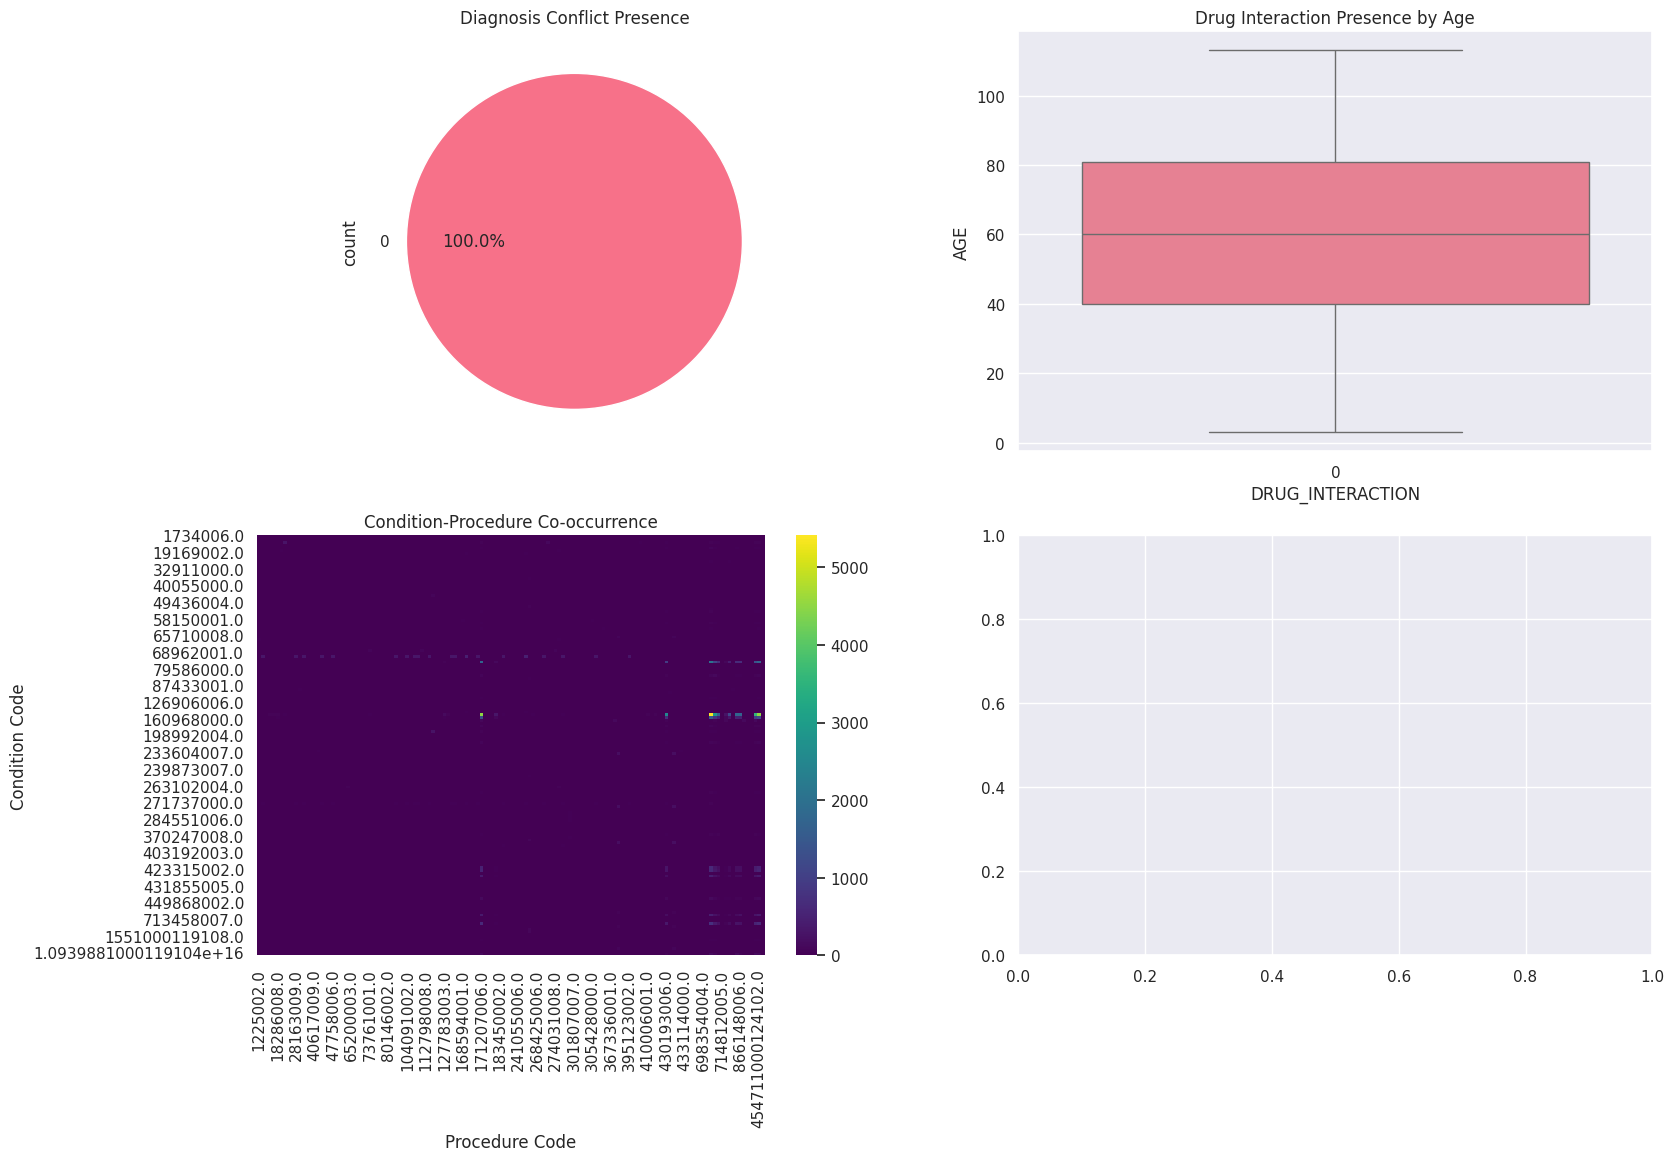

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
import pandas as pd
from config.config import Config

sns.set_theme(style="darkgrid")
sns.set_palette("husl")
class HealthcareEDA:
    def __init__(self, features_df: pd.DataFrame):
        self.df = features_df
        self.output_dir = Config.ARTIFACTS / "eda_plots"
        self.output_dir.mkdir(exist_ok=True)
        
    def plot_distributions(self):
        """Plot distributions of key numerical features"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Age Distribution
        sns.histplot(self.df['AGE'], bins=30, kde=True, ax=axes[0,0])
        axes[0,0].set_title('Patient Age Distribution')
        axes[0,0].set_xlabel('Age')
        axes[0,0].set_ylabel('Count')
        
        # Encounter Cost Distribution
        sns.boxplot(x=self.df['ENCOUNTER_COST_MEAN'], ax=axes[0,1])
        axes[0,1].set_title('Average Encounter Cost Distribution')
        axes[0,1].set_xlabel('Cost ($)')
        
        # Medication Count Distribution
        sns.countplot(x=self.df['MED_COUNT'], ax=axes[1,0])
        axes[1,0].set_title('Medication Count Distribution')
        axes[1,0].set_xlabel('Number of Medications')
        
        # Temporal Features
        sns.lineplot(x='START', y='BASE_ENCOUNTER_COST', 
                    data=self.df, ax=axes[1,1])
        axes[1,1].set_title('Encounter Cost Over Time')
        axes[1,1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.savefig(self.output_dir / 'distributions.png')
        plt.close()

    def plot_clinical_features(self):
        """Visualize clinical features and relationships"""
        fig = plt.figure(figsize=(18, 12))
        
        # Diagnosis Conflict Analysis
        plt.subplot(2, 2, 1)
        self.df['DIAGNOSIS_CONFLICT'].value_counts().plot.pie(autopct='%1.1f%%')
        plt.title('Diagnosis Conflict Presence')
        
        # Drug Interactions by Age
        plt.subplot(2, 2, 2)
        sns.boxplot(x='DRUG_INTERACTION', y='AGE', data=self.df)
        plt.title('Drug Interaction Presence by Age')
        
        # Condition-Procedure Relationship
        plt.subplot(2, 2, 3)
        cross_tab = pd.crosstab(self.df['COND_CODE'], self.df['PROC_CODE'])
        sns.heatmap(cross_tab, cmap='viridis')
        plt.title('Condition-Procedure Co-occurrence')
        plt.xlabel('Procedure Code')
        plt.ylabel('Condition Code')
        
        # Temporal Visit Patterns
        plt.subplot(2, 2, 4)
        self.df['VISIT_MONTH'] = self.df['START'].dt.month
        monthly_counts = self.df.groupby('VISIT_MONTH').size()
        sns.lineplot(x=monthly_counts.index, y=monthly_counts.values)
        plt.title('Monthly Visit Trends')
        plt.xlabel('Month')
        plt.ylabel('Number of Visits')
        
        plt.tight_layout()
        plt.savefig(self.output_dir / 'clinical_features.png')
        plt.close()

    def plot_correlations(self):
        """Visualize feature correlations"""
        numerical_features = ['AGE', 'ENCOUNTER_COST_MEAN', 
                             'MED_COUNT', 'TOTAL_CLAIM_SUM']
        
        corr_matrix = self.df[numerical_features].corr()
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
        plt.title('Feature Correlation Matrix')
        plt.savefig(self.output_dir / 'correlations.png')
        plt.close()

    def plot_demographics(self):
        """Analyze patient demographics"""
        fig, axes = plt.subplots(1, 3, figsize=(20, 6))
        
        # Gender Distribution
        self.df['GENDER'].value_counts().plot.pie(autopct='%1.1f%%', ax=axes[0])
        axes[0].set_title('Gender Distribution')
        
        # Ethnicity Distribution
        self.df['ETHNICITY'].value_counts().plot.bar(ax=axes[1])
        axes[1].set_title('Ethnicity Distribution')
        axes[1].tick_params(axis='x', rotation=45)
        
        # Age vs Healthcare Costs
        sns.scatterplot(x='AGE', y='TOTAL_CLAIM_SUM', 
                       data=self.df, ax=axes[2])
        axes[2].set_title('Age vs Total Claim Costs')
        axes[2].set_ylabel('Total Claim Amount ($)')
        
        plt.tight_layout()
        plt.savefig(self.output_dir / 'demographics.png')
        plt.close()

    def plot_anomalies(self):
        """Visualize potential anomalies"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # High Cost Encounters
        sns.boxplot(x=self.df['BASE_ENCOUNTER_COST'], ax=axes[0,0])
        axes[0,0].set_title('Base Encounter Cost Distribution')
        
        # Frequent Visitors
        visitor_counts = self.df['PATIENT'].value_counts()
        sns.histplot(visitor_counts, bins=30, ax=axes[0,1])
        axes[0,1].set_title('Patient Visit Frequency')
        axes[0,1].set_xlabel('Number of Visits')
        
        # Temporal Anomalies
        self.df['HOUR'] = self.df['START'].dt.hour
        sns.countplot(x='HOUR', data=self.df, ax=axes[1,0])
        axes[1,0].set_title('Visit Time Distribution')
        
        # Missing Data
        missing = self.df.isna().sum().sort_values(ascending=False)
        sns.barplot(x=missing.values, y=missing.index, ax=axes[1,1])
        axes[1,1].set_title('Missing Values per Feature')
        
        plt.tight_layout()
        plt.savefig(self.output_dir / 'anomalies.png')
        plt.close()

    def generate_all_reports(self):
        """Execute all EDA plots"""
        self.plot_distributions()
        self.plot_clinical_features()
        self.plot_correlations()
        self.plot_demographics()
        self.plot_anomalies()
        logger.info(f"All EDA plots saved to {self.output_dir}")


if __name__ == "__main__":
    # Load processed data
    features_df = pd.read_csv(Config.DATA_PROCESSED / 'features.csv')
    # Generate plots
    eda = HealthcareEDA(features_df)
    eda.generate_all_reports()